# Pylops - Signal Processing on GPU with cupy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.wavelets import *
from pylops.utils.seismicevents import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.basic import cgls
from pylops.optimization.leastsquares import *
from pylops.optimization.sparsity import *

cp.cuda.Device(device=1).use()

## FFT

Dot test passed, v^H(Opu)=(-5.004816493943258-0.3269446297731715j) - u^H(Op^Hv)=(-5.004816493943256-0.3269446297731746j)


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


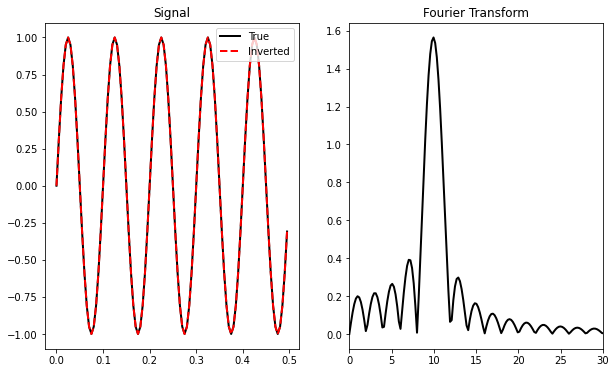

In [2]:
dt   = 0.005
nt   = 100
t    = cp.arange(nt)*dt
f0   = 10
nfft = 2**10
d  = cp.sin(2*np.pi*f0*t)

FFTop = FFT(dims=[nt], nfft=nfft, sampling=dt)
dottest(FFTop, nfft, nt, complexflag=3, verb=True, backend='cupy')

D    = FFTop*d
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = FFTop / D

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].plot(cp.asnumpy(t), cp.asnumpy(d),    'k',  lw=2, label='True')
axs[0].plot(cp.asnumpy(t), cp.asnumpy(dinv),'--r',lw=2, label='Inverted')
axs[0].legend()
axs[0].set_title('Signal')
axs[1].plot(cp.asnumpy(FFTop.f[:int(FFTop.nfft/2)]), 
            cp.asnumpy(np.abs(D[:int(FFTop.nfft/2)])),'k',lw=2)
axs[1].set_title('Fourier Transform')
axs[1].set_xlim([0,3*f0]);

Dot test passed, v^H(Opu)=(74.25602074881628-13.375947219019306j) - u^H(Op^Hv)=(74.25602074881628-13.37594721901931j)


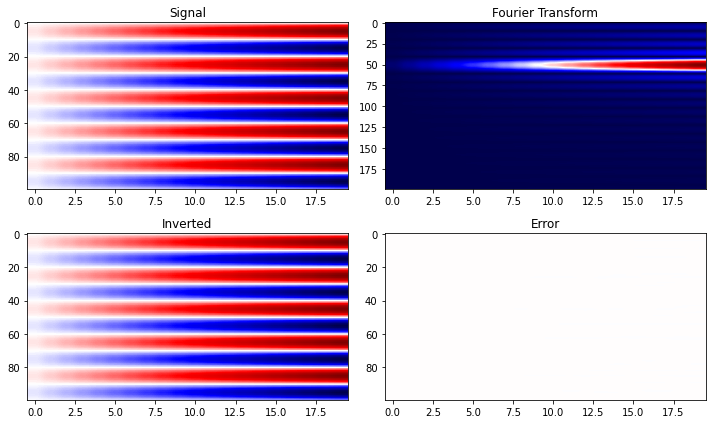

In [3]:
dt     = 0.005
nt,nx  = 100, 20
t      = cp.arange(nt)*dt
f0     = 10
nfft   = 2**10
d      = cp.outer(cp.sin(2*np.pi*f0*t), cp.arange(nx)+1)

FFTop = FFT(dims=[nt,nx], axis=0, nfft=nfft, sampling=dt)
dottest(FFTop, nfft*nx, nt*nx, complexflag=2, verb=True, backend='cupy')

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = cp.real(FFTop / D).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(cp.asnumpy(d), vmin=-20, vmax=20, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(np.abs(D.reshape(nfft,nx)[:200,:])), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(cp.asnumpy(dinv), vmin=-20, vmax=20, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(d-dinv), vmin=-20, vmax=20, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout();

Dot test passed, v^H(Opu)=(-96.04612548636008+64.98601740800953j) - u^H(Op^Hv)=(-96.04612548636018+64.98601740800969j)


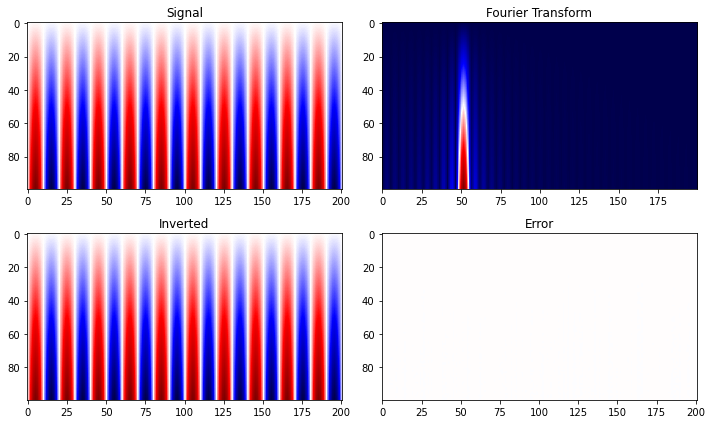

In [4]:
dx     = 0.005
nt,nx  = 100, 201
x      = cp.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = cp.outer(cp.arange(nt)+1, cp.sin(2*np.pi*f0*x))

FFTop = FFT(dims=[nt,nx], axis=1, nfft=nfft, sampling=dt)
dottest(FFTop, nt*nfft, nt*nx, complexflag=2, verb=True, backend='cupy')

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = cp.real(FFTop / D).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(cp.asnumpy(d), vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(np.abs(D.reshape(nt,nfft)[:,:200])), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(cp.asnumpy(dinv), vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(d-dinv), vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

Dot test passed, v^H(Opu)=(51.284844021123675-373.98055590915635j) - u^H(Op^Hv)=(51.28484402112366-373.98055590915646j)


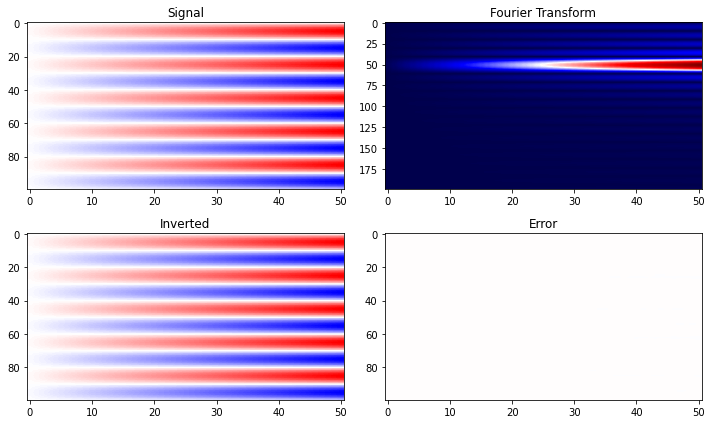

In [5]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 6
t      = cp.arange(nt)*dt
f0     = 10
nfft   = 2**10
d      = cp.outer(cp.sin(2*np.pi*f0*t), cp.arange(nx)+1)
d      = cp.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT(dims=[nt,nx,ny], axis=0, nfft=nfft, sampling=dt)
dottest(FFTop, nfft*nx*ny, nt*nx*ny, complexflag=2, verb=True, backend='cupy')

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = cp.real(FFTop / D).reshape(nt,nx,ny)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(cp.asnumpy(d[:,:,ny//2]), vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(np.abs(D.reshape(nfft,nx,ny)[:200,:,ny//2])), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(cp.asnumpy(dinv[:,:,ny//2]), vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(d[:,:,ny//2]-dinv[:,:,ny//2]), vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

## FFT2D

In [6]:
dt, dx = 0.005, 5
nt,nx  = 100, 201
t      = cp.arange(nt)*dt
x      = cp.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = cp.outer(cp.sin(2*np.pi*f0*t), cp.arange(nx)+1)

FFTop = FFT2D(dims=[nt,nx], nffts=[nfft,nfft], sampling=[dt,dx])

dottest(FFTop, nfft*nfft, nt*nx, complexflag=2, verb=True, backend='cupy')

Dot test passed, v^H(Opu)=(-174.40353640467384+75.11070354706862j) - u^H(Op^Hv)=(-174.403536404674+75.11070354706845j)


True

Dot test passed, v^H(Opu)=(-85.05810286666056+223.1307237348347j) - u^H(Op^Hv)=(-85.0581028666608+223.13072373483485j)


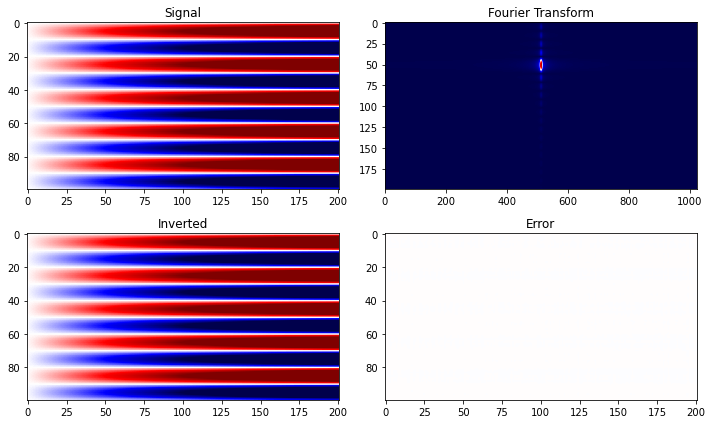

In [7]:
dt, dx = 0.005, 5
nt,nx  = 100, 201
t      = cp.arange(nt)*dt
x      = cp.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = cp.outer(cp.sin(2*np.pi*f0*t), cp.arange(nx)+1)

FFTop = FFT2D(dims=[nt,nx], nffts=[nfft,nfft], sampling=[dt,dx])
dottest(FFTop, nfft*nfft, nt*nx, complexflag=2, verb=True, backend='cupy')

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = cp.real(FFTop / D).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(cp.asnumpy(d), vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:])), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(cp.asnumpy(dinv), vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(d-dinv), vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

In [8]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 31
t      = cp.arange(nt)*dt
f0     = 10
nfft   = 2**8
d      = cp.outer(cp.sin(2*np.pi*f0*t), cp.arange(nx)+1)
d      = cp.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx])
dottest(FFTop, nt*nfft*nfft, nt*nx*ny, complexflag=2, verb=True, backend='cupy')

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = cp.real(FFTop / D).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^H(Opu)=(549.0147027554913-110.30627381578093j) - u^H(Op^Hv)=(549.014702755488-110.30627381577895j)
1.5736742523903425e-12


## 1D Convolution

In [9]:
nx = 10
x  = cp.zeros(nx)
x[3]=1
offset=4
h = cp.arange(-3, 3)
print(h)
Cop = Convolve1D(nx, h=h, offset=offset, 
                 dtype='float32', method='direct')
dottest(Cop, nx, nx, verb=True, backend='cupy')

y    = Cop*x
xadj = Cop.H*x

print('x= ',x)
print('y= ',y)
print('xadj= ',xadj)

[-3 -2 -1  0  1  2]
Dot test passed, v^H(Opu)=2.347539959850635 - u^H(Op^Hv)=2.347539959850635
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [ 0.  0.  2.  1.  0. -1. -2. -3.  0.  0.]


Dot test passed, v^H(Opu)=-6.76225789251694 - u^H(Op^Hv)=-6.762262407271244


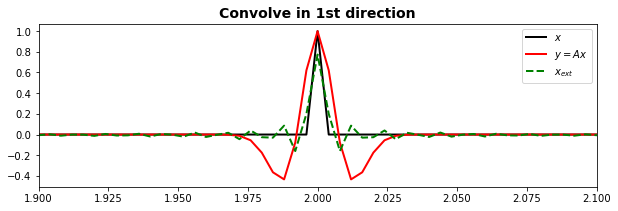

In [10]:
nt = 1001
dt = 0.004
t  = np.arange(nt)*dt
x  = cp.zeros(nt)
x[int(nt/2)] = 1

h, th, hcenter = ricker(t[:101], f0=30)
    
Cop = Convolve1D(nt, h=cp.array(h), offset=hcenter, dtype='float32')
dottest(Cop, nt, nt, verb=True, atol=1e-3, backend='cupy')
y = Cop*x
xcgls = cgls(Cop, y, x0=cp.zeros(nt), damp=0, tol=0, niter=1000, show=0)[0]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=2, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=2, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xcgls), '--g', lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim(1.9,2.1);

Dot test passed, v^H(Opu)=-66.50165935465917 - u^H(Op^Hv)=-66.50166698106625


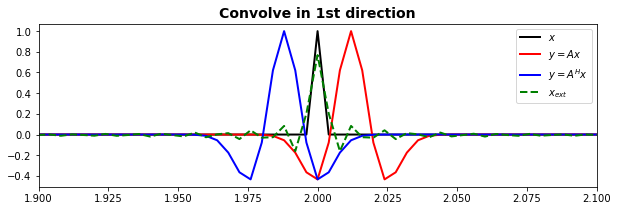

In [11]:
nt = 1001
dt = 0.004
t  = cp.arange(nt)*dt
x  = cp.zeros(nt)
x[int(nt/2)] = 1

h, th, hcenter = ricker(t[:101], f0=30)

Cop = Convolve1D(nt, h=h, offset=hcenter-3, dtype='float32')
dottest(Cop, nt, nt, verb=True, atol=1e-3, backend='cupy')

y    = Cop*x
y1   = Cop.H*x
xcgls = cgls(Cop, y, x0=cp.zeros(nt), damp=0, tol=0, niter=1000, show=0)[0]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=2, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=2, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y1), 'b', lw=2, label=r'$y=A^Hx$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xcgls), '--g', lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim(1.9,2.1);

<class 'cupy._core.core.ndarray'>


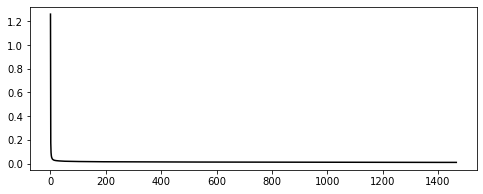

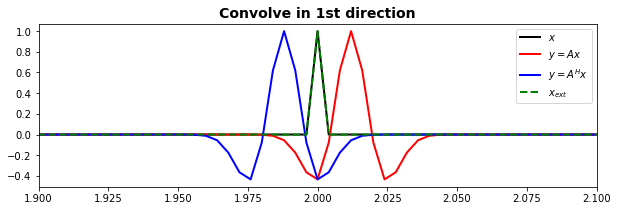

In [12]:
xista, niter, cost = ista(Cop, y, niter=10000, eps=0.01, alpha=0.1)
print(type(xista))
plt.figure(figsize=(8, 3))
plt.plot(cost, 'k')

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=2, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=2, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y1), 'b', lw=2, label=r'$y=A^Hx$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xista), '--g', lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim(1.9,2.1);

Dot test passed, v^H(Opu)=203.88348210746594 - u^H(Op^Hv)=203.88347911031232


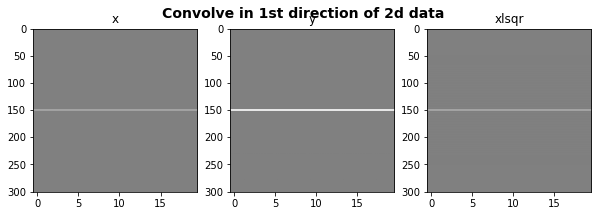

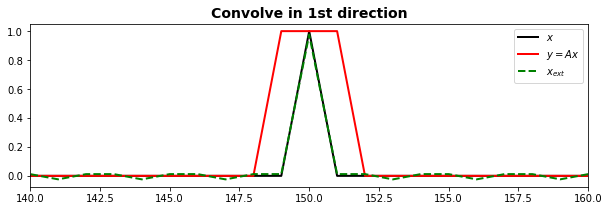

In [13]:
nt = 301
nx = 20
dt = 0.004
t  = cp.arange(nt)*dt
x  = cp.zeros((nt, nx))
x[int(nt/2),:] = 1

h = np.ones(3)
hcenter=1

Cop = Convolve1D(dims=[nt,nx], h=h, offset=hcenter, axis=0, dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True, backend='cupy', atol=1e-3)

y    = Cop*x.flatten()
xcgls = cgls(Cop, y, x0=cp.zeros(nt*nx), damp=0, niter=1000, show=0)[0]

y = y.reshape(nt,nx)
xcgls = xcgls.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(cp.asnumpy(x), cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(cp.asnumpy(y), cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(cp.asnumpy(xcgls), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(cp.asnumpy(x)[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(cp.asnumpy(y)[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(cp.asnumpy(xcgls)[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(140,160);

Dot test passed, v^H(Opu)=-48.310782921627776 - u^H(Op^Hv)=-48.31062478453714


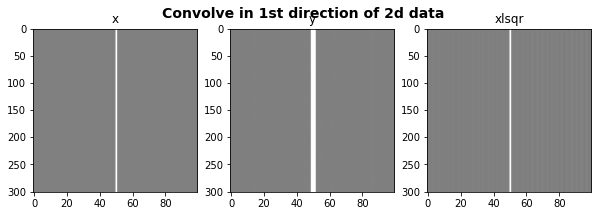

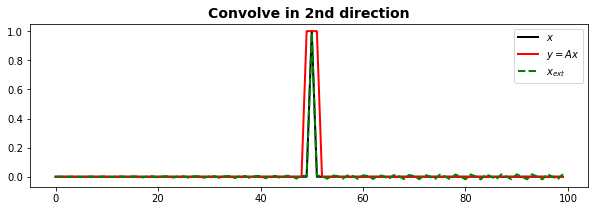

In [14]:
nt = 301
nx = 100
dt = 0.004
t  = cp.arange(nt)*dt
x  = cp.zeros((nt, nx))
x[:, int(nx/2)] = 1

h = np.ones(3)
hcenter=1

Cop = Convolve1D(dims=[nt,nx], h=h, offset=hcenter,axis=-1, dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True, backend='cupy', atol=1e-3)

y = Cop*x.flatten()
xcgls = cgls(Cop, y, x0=cp.zeros(nt*nx), damp=0, niter=1000, show=0)[0]

y = y.reshape(nt,nx)
xcgls = xcgls.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(cp.asnumpy(x), cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(cp.asnumpy(y), cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(cp.asnumpy(xcgls), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(cp.asnumpy(x)[int(nt/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(cp.asnumpy(y)[int(nt/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(cp.asnumpy(xcgls)[int(nt/2)],'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 2nd direction',fontsize=14, fontweight='bold')
ax.legend();

## Preconditioned inversion with smoothing

Dot test passed, v^H(Opu)=-5.341288886642637 - u^H(Op^Hv)=-5.341288886642639


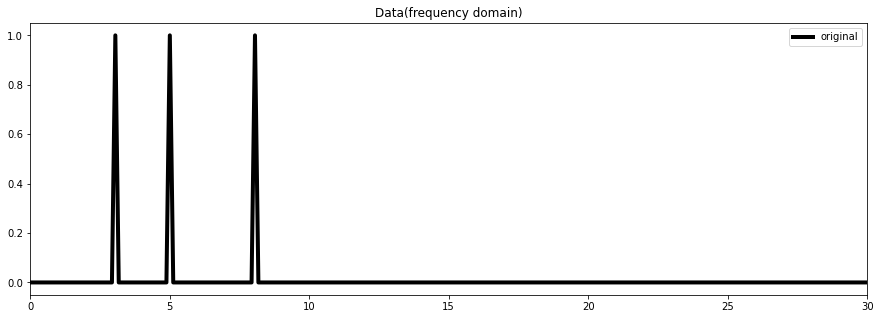

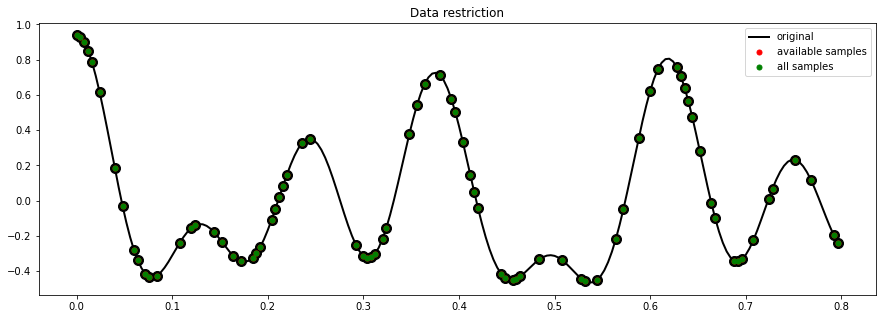

In [15]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = cp.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(cp.asnumpy(X)), 'k', lw=4, label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N, verb=True, backend='cupy')

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),       'k' , lw=2,   label='original')
plt.plot(t[iava], cp.asnumpy(x)[iava], '.k', ms=20)
plt.plot(t[iava], cp.asnumpy(y),       '.r', ms=10, label='available samples')
plt.plot(t,       ymask,               '.g', ms=10, label='all samples')
plt.legend()
plt.title('Data restriction');

PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 80 rows and 200 cols
Prec=<200x200 Convolve1D with dtype=float64>
-----------------------------------------------------------------
CGLS
-----------------------------------------------------------------
The Operator Op has 80 rows and 200 cols
damp = 6.400000e-03	tol = 1.000000e-04	niter = 20
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        1.0335e+00         9.4030e-01     1.0490e+00
     2        1.1934e+00         5.2076e-01     7.1940e-01
     3        1.2817e+00         3.8207e-01     6.3548e-01
     4        1.4721e+00         3.0254e-01     5.9832e-01
     5        1.5662e+00         2.6975e-01     5.8599e-01
     6        1.6837e+00         2.3662e-01     5.7575e-01
     7        1.7546e+00         2.1900e-01     5.7125e-01
     8        1.8345e+00         1.9970e-01     5.6714e-01


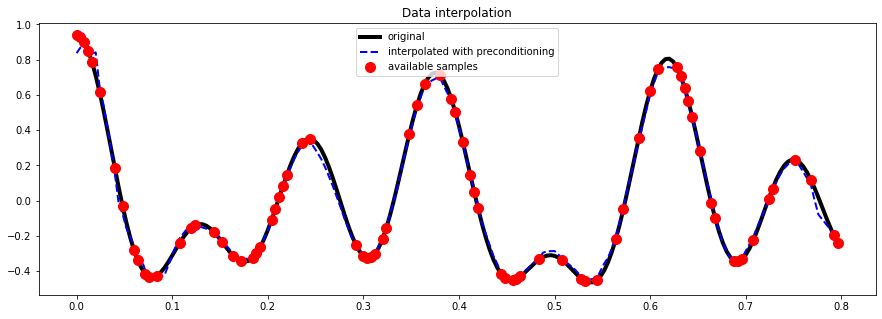

In [16]:
# Create preconditioner
Sop  = Smoothing1D(nsmooth=11, dims=[N], dtype='float64')

# Invert for interpolated signal
xprec, istop, itn, r1norm, r2norm = \
    preconditioned_inversion(Rop, y, Sop, engine='pylops', **dict(damp=8e-2, niter=20, show=1))

print('lsqr reason for termination=', istop)
print('lsqr number of iterations=', itn)
print('lsqr residual norm of iterations=', r1norm)
print('lsqr regularized residual norm=', r2norm)

fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),      'k'   , lw=4,   label='original')
plt.plot(t,       cp.asnumpy(xprec),  '--b' , lw=2,   label='interpolated with preconditioning')
plt.plot(t[iava], cp.asnumpy(y),      '.r'  , ms=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

## Bilinear

In [17]:
from scipy import misc

x = cp.array(misc.face()[::5, ::5, 0])
nz, nx = x.shape

nsamples = 2000
iava = cp.vstack((cp.random.uniform(0, nz-1, nsamples),
                  cp.random.uniform(0, nx-1, nsamples)))

Bop = Bilinear(iava, (nz, nx))
y = Bop * x.ravel()

D2op = Laplacian((nz, nx), weights=(1, 1), dtype='float64')

xadj = Bop.H * y

dottest(Bop, Bop.shape[0], Bop.shape[1], verb=True, backend='cupy');

Dot test passed, v^H(Opu)=1.3164589694930866 - u^H(Op^Hv)=1.316458969493091


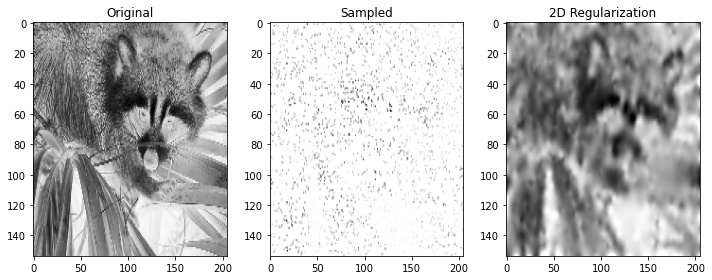

In [18]:
xinv = normal_equations_inversion(Bop, y, [D2op], epsRs=[np.sqrt(0.1)], 
                                  engine='pylops', **dict(niter=100))[0]
xadj = xadj.reshape(nz, nx)
xinv = xinv.reshape(nz, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(cp.asnumpy(x), cmap='gray_r', vmin=0, vmax=250)
axs[0].axis('tight')
axs[0].set_title('Original')
axs[1].imshow(cp.asnumpy(xadj), cmap='gray_r', vmin=0, vmax=250)
axs[1].axis('tight')
axs[1].set_title('Sampled')
axs[2].imshow(cp.asnumpy(xinv), cmap='gray_r', vmin=0, vmax=250)
axs[2].axis('tight')
axs[2].set_title('2D Regularization')
plt.tight_layout();

## Convolve2D

Dot test passed, v^H(Opu)=-295.9367003087716 - u^H(Op^Hv)=-295.93670030877206


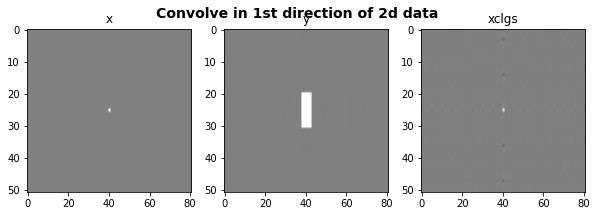

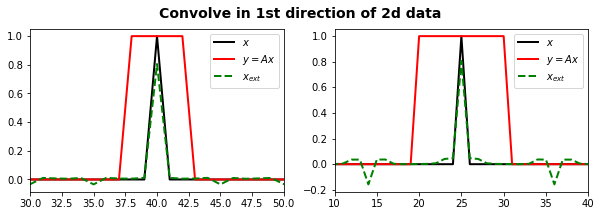

In [19]:
nt = 51
nx = 81
dt = 0.004
t  = cp.arange(nt)*dt
x  = cp.zeros((nt,nx))
x[int(nt/2),int(nx/2)] = 1

nh = [11,5]
h  = cp.ones((nh[0], nh[1]))

Cop = Convolve2D(dims=[nt,nx], h=h, offset=[int(nh[0])/2,int(nh[1])/2], 
                 dtype='float64')
dottest(Cop, nt*nx, nt*nx, verb=True, backend='cupy')

y    = Cop*x.flatten()

xcgls = cgls(Cop, y, cp.zeros(nx*nt), damp=0, niter=500, show=0)[0]

y = y.reshape(nt,nx)
xcgls = xcgls.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(cp.asnumpy(x), cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(cp.asnumpy(y), cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(cp.asnumpy(xcgls), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xclgs'),axs[2].axis('tight')

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(cp.asnumpy(x)[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(cp.asnumpy(y)[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(cp.asnumpy(xcgls)[int(nt/2), :],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(cp.asnumpy(x)[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(cp.asnumpy(y)[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(cp.asnumpy(xcgls)[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend()
ax[0].set_xlim(30,50)
ax[1].legend()
ax[1].set_xlim(10,40);

Dot test passed, v^H(Opu)=512.8704960265904 - u^H(Op^Hv)=512.87038020589


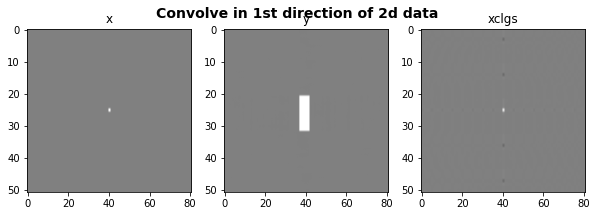

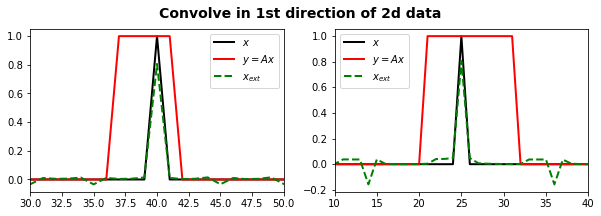

In [20]:
nt = 51
nx = 81
dt = 0.004
t  = cp.arange(nt)*dt
x  = cp.zeros((nt,nx))
x[int(nt/2),int(nx/2)] = 1

nh = [11,5]
h  = cp.ones((nh[0],nh[1]))

Cop = Convolve2D(dims=[nt,nx], h=h, offset=[int(nh[0])/2-1,int(nh[1])/2+1], 
                 dtype='float32', method='fft')
dottest(Cop, nt*nx, nt*nx, verb=True, backend='cupy', atol=1e-3)

y    = Cop*x.flatten()

xcgls = cgls(Cop, y, cp.zeros(nx*nt), damp=0, niter=500, show=0)[0]

y = y.reshape(nt,nx)
xcgls = xcgls.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(cp.asnumpy(x), cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(cp.asnumpy(y), cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(cp.asnumpy(xcgls), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xclgs'),axs[2].axis('tight')

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(cp.asnumpy(x)[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(cp.asnumpy(y)[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(cp.asnumpy(xcgls)[int(nt/2), :],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(cp.asnumpy(x)[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(cp.asnumpy(y)[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(cp.asnumpy(xcgls)[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend()
ax[0].set_xlim(30,50)
ax[1].legend()
ax[1].set_xlim(10,40);

Dot test passed, v^H(Opu)=284.8441452761921 - u^H(Op^Hv)=284.8441452761919


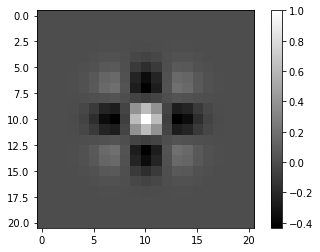

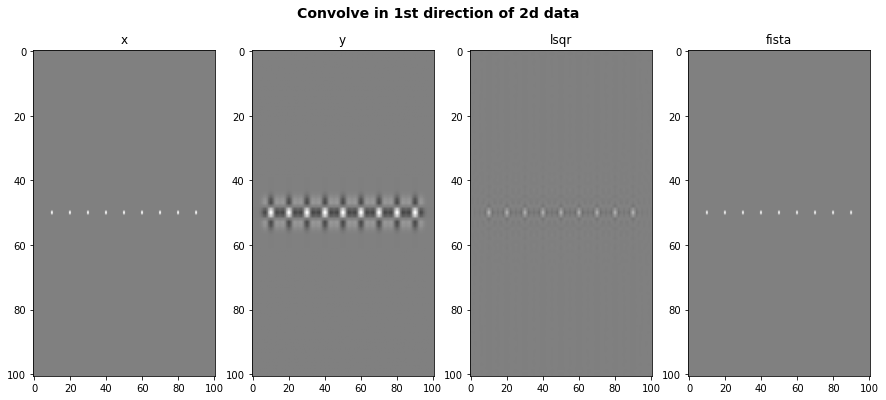

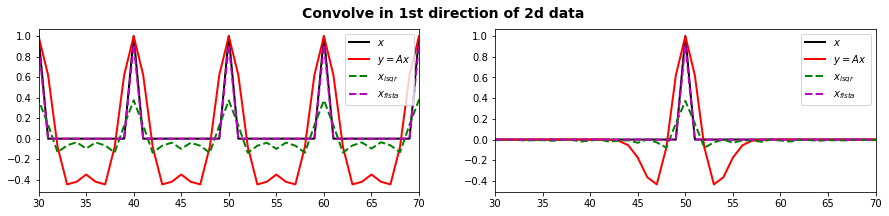

In [21]:
# Oscillating filter

# create 2d wavelet
nt = 31
dt = 0.004
t  = np.arange(nt)*dt
h, th, hcenter = ricker(t, f0=30)

imp = np.zeros((21, 21))
imp[10, 10] = 1
imp = fftconvolve(imp, h[:, np.newaxis], mode='same', axes=0)
imp = fftconvolve(imp, h[np.newaxis, :], mode='same', axes=1)
imp = cp.array(imp)

plt.figure()
plt.imshow(cp.asnumpy(imp), cmap='gray')
plt.colorbar()

nt = 101
nx = 101
x = cp.zeros((nt,nx))
x[int(nt/2), 10:-10:10] = 1

Cop = Convolve2D(dims=[nt,nx], h=imp, offset=[imp.shape[0]//2, imp.shape[1]//2], 
                 dtype='float64')
dottest(Cop, nt*nx, nt*nx, verb=True, atol=1e-3, backend='cupy')
y    = Cop*x.flatten()

xcgls = cgls(Cop, y, cp.zeros(nx*nt), damp=0, niter=500, show=0)[0]
xfista = fista(Cop, y, eps=1e0, niter=100, show=0)[0]

y = y.reshape(nt,nx)
xcgls = xcgls.reshape(nt,nx)
xfista = xfista.reshape(nt,nx)

fig, axs = plt.subplots(1,4,figsize=(15,6))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(cp.asnumpy(x), cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(cp.asnumpy(y), cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(cp.asnumpy(xcgls), cmap='gray', vmin=-1, vmax=1)
axs[3].imshow(cp.asnumpy(xfista), cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('lsqr'),axs[2].axis('tight');
axs[3].set_title('fista'),axs[3].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(15,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(cp.asnumpy(x)[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(cp.asnumpy(y)[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(cp.asnumpy(xcgls)[int(nt/2), :],'--g',lw=2, label=r'$x_{lsqr}$')
ax[0].plot(cp.asnumpy(xfista)[int(nt/2), :],'--m',lw=2, label=r'$x_{fista}$')
ax[1].plot(cp.asnumpy(x)[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(cp.asnumpy(y)[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(cp.asnumpy(xcgls)[:, int(nx/2)],'--g',lw=2, label=r'$x_{lsqr}$')
ax[1].plot(cp.asnumpy(xfista)[:, int(nx/2)],'--m',lw=2, label=r'$x_{fista}$')
ax[0].legend();
ax[0].set_xlim(30,70);
ax[1].legend();
ax[1].set_xlim(30,70);

Dot test passed, v^H(Opu)=-491.36656214629863 - u^H(Op^Hv)=-491.3666520872281


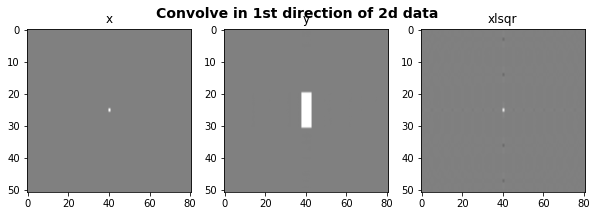

In [22]:
#2D Conv on 3D signal
nt = 51
nx = 81
ny = 11
dt = 0.004
t  = np.arange(nt)*dt
x  = cp.zeros((nt, nx, ny))
x[int(nt/2), int(nx/2), int(ny/2)] = 1

nh = [11,5]
h  = cp.ones((nh[0], nh[1]))

Cop = Convolve2D(dims=[nt,nx,ny], h=h, offset=[int(nh[0])/2,int(nh[1])/2], 
                 axes=(0, 1), dtype='float32')
dottest(Cop, nt*nx*ny, nt*nx*ny, verb=True, atol=1e-3, backend='cupy')

y    = Cop*x.flatten()

xcgls = cgls(Cop, y, cp.zeros(ny*nx*nt), damp=0, niter=500, show=0)[0]

y = y.reshape(nt,nx,ny)
xcgls = xcgls.reshape(nt,nx,ny)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(cp.asnumpy(x)[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(cp.asnumpy(y)[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(cp.asnumpy(xcgls)[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'), axs[0].axis('tight')
axs[1].set_title('y'), axs[1].axis('tight')
axs[2].set_title('xlsqr'), axs[2].axis('tight');

## ConvolveND

Dot test passed, v^H(Opu)=510.22699447904563 - u^H(Op^Hv)=510.22699447904506


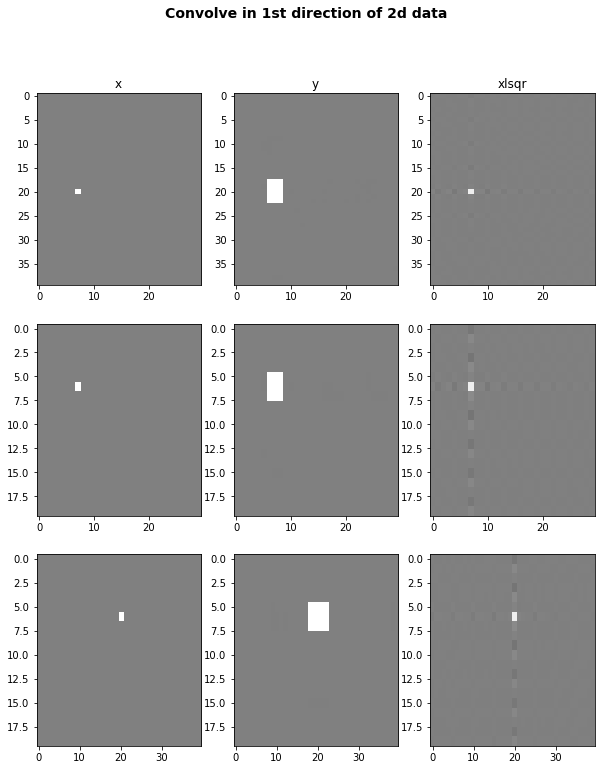

In [23]:
ny, nx, nz = 20, 40, 30
x = cp.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = cp.ones((3, 5, 3))
offset = [1, 2, 1]

Cop = ConvolveND(dims=[ny, nx, nz], h=h, offset=offset, 
                 axes=[0,1,2], dtype='float64')
dottest(Cop, ny*nx*nz, ny*nx*nz, verb=True, atol=1e-3, backend='cupy')

y    = Cop*x.flatten()
xcgls = cgls(Cop, y, cp.zeros(ny*nx*nz), damp=0, niter=500, show=0)[0]

y = y.reshape(ny, nx, nz)
xcgls = xcgls.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(cp.asnumpy(x)[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(cp.asnumpy(y)[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(cp.asnumpy(xcgls)[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(cp.asnumpy(x)[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(cp.asnumpy(y)[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(cp.asnumpy(xcgls)[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight');
axs[2][0].imshow(cp.asnumpy(x)[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(cp.asnumpy(y)[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(cp.asnumpy(xcgls)[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');

## Interp

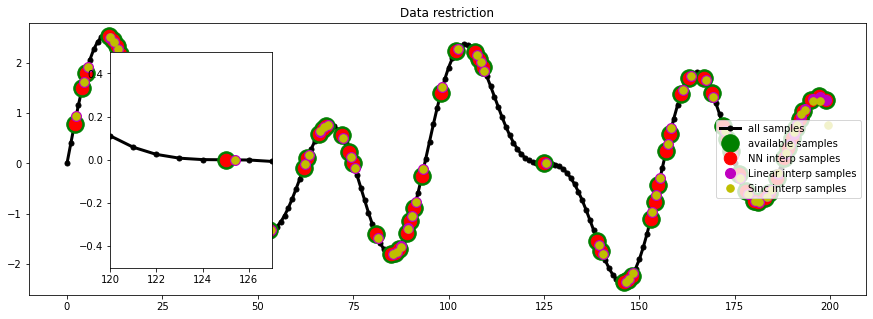

In [24]:
nt = 200
dt = 0.004

freqs = [5., 3., 8.]

t = cp.arange(nt)*dt
x = cp.zeros(nt)

for freq in freqs:
    x = x + cp.sin(2*np.pi*freq*t)

perc_subsampling = 0.4
ntsub = int(np.round(nt*perc_subsampling))

isample = cp.arange(nt)
iava = cp.sort(cp.random.permutation(cp.arange(nt))[:ntsub])

Rop = Restriction(nt, iava, dtype='float64')
NNop, iavann = Interp(nt, iava + 0.4, kind='nearest', dtype='float64')
LIop, iavali = Interp(nt, iava+0.4,   kind='linear', dtype='float64')
SIop, iavasi = Interp(nt, iava + 0.4, kind='sinc', dtype='float64')
y = Rop*x
ynn = NNop*x
yli = LIop*x
ysi = SIop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15, 5))
plt.plot(cp.asnumpy(isample), cp.asnumpy(x), '.-k', lw=3, ms=10, label='all samples')
plt.plot(cp.asnumpy(isample), ymask, '.g', ms=35, label='available samples')
plt.plot(cp.asnumpy(iavann), cp.asnumpy(ynn), '.r', ms=25, label='NN interp samples')
plt.plot(cp.asnumpy(iavali), cp.asnumpy(yli), '.m', ms=20, label='Linear interp samples')
plt.plot(cp.asnumpy(iavasi), cp.asnumpy(ysi), '.y', ms=15, label='Sinc interp samples')
plt.legend(loc='right')
plt.title('Data restriction')

subax = fig.add_axes([0.2, 0.2, 0.15, 0.6])
subax.plot(cp.asnumpy(isample), cp.asnumpy(x), '.-k', lw=3, ms=10)
subax.plot(cp.asnumpy(isample), ymask, '.g', ms=35)
subax.plot(cp.asnumpy(iavann), cp.asnumpy(ynn), '.r', ms=25)
subax.plot(cp.asnumpy(iavali), cp.asnumpy(yli), '.m', ms=20)
subax.plot(cp.asnumpy(iavasi), cp.asnumpy(ysi), '.y', ms=15)
subax.set_xlim([120, 127])
subax.set_ylim([-0.5, 0.5]);

## Smoothing1D

Dot test passed, v^H(Opu)=-1.0592651360320466 - u^H(Op^Hv)=-1.0592651360320473


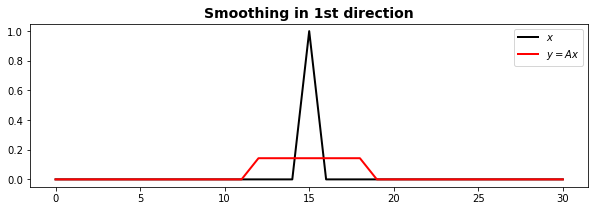

In [25]:
N = 31
nsmooth = 7
x = cp.zeros(N)
x[int(N/2)] = 1

Sop = Smoothing1D(nsmooth=nsmooth, dims=[N], dtype='float32')
dottest(Sop, N, N, verb=True, backend='cupy')

y = Sop*x
xadj = Sop.H*y

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(cp.asnumpy(x), 'k', lw=2, label=r'$x$')
ax.plot(cp.asnumpy(y), 'r', lw=2, label=r'$y=Ax$')
ax.set_title('Smoothing in 1st direction', fontsize=14, fontweight='bold')
ax.legend();

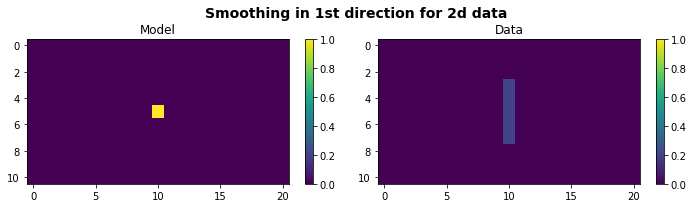

In [26]:
A = cp.zeros((11, 21))
A[5, 10] = 1

Sop = Smoothing1D(nsmooth=5, dims=(11, 21), axis=0, dtype='float64')
B = np.reshape(Sop*A.ravel(), (11, 21))

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Smoothing in 1st direction for 2d data', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(cp.asnumpy(A), interpolation='nearest', vmin=0, vmax=1)
axs[0].axis('tight')
axs[0].set_title('Model')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(cp.asnumpy(B), interpolation='nearest', vmin=0, vmax=1)
axs[1].axis('tight')
axs[1].set_title('Data')
plt.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.subplots_adjust(top=0.8)

## Smoothing2D

Dot test passed, v^H(Opu)=-0.5336735944011357 - u^H(Op^Hv)=-0.533673594401136


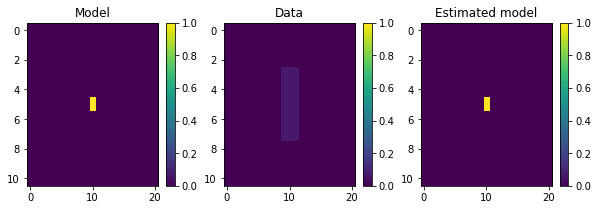

In [27]:
N, M = 11, 21
nsmooth1, nsmooth2 = 5, 3
A = np.zeros((N, M))
A[5, 10] = 1

Sop = Smoothing2D(nsmooth=[nsmooth1, nsmooth2], dims=[N, M], dtype='float64')
dottest(Sop, N*M, N*M, verb=True, backend='cupy')

B = Sop*A.flatten()
B = B.reshape(N, M)

#Aest = Sop.div(B.flatten(), **dict(niter=100))
Aest = cgls(Sop, B.flatten(), x0=cp.zeros(N*M), damp=0, 
            niter=1000, tol=0)[0]
Aest = np.reshape(Aest, (N, M))

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
im = axs[0].imshow(cp.asnumpy(A), interpolation='nearest', vmin=0, vmax=1)
axs[0].axis('tight')
axs[0].set_title('Model')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(cp.asnumpy(B), interpolation='nearest', vmin=0, vmax=1)
axs[1].axis('tight')
axs[1].set_title('Data')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(cp.asnumpy(Aest), interpolation='nearest', vmin=0, vmax=1)
axs[2].axis('tight')
axs[2].set_title('Estimated model')
plt.colorbar(im, ax=axs[2])


## Sliding2D

Dot test passed, v^H(Opu)=-707.5022315013821 - u^H(Op^Hv)=-707.5022315013825


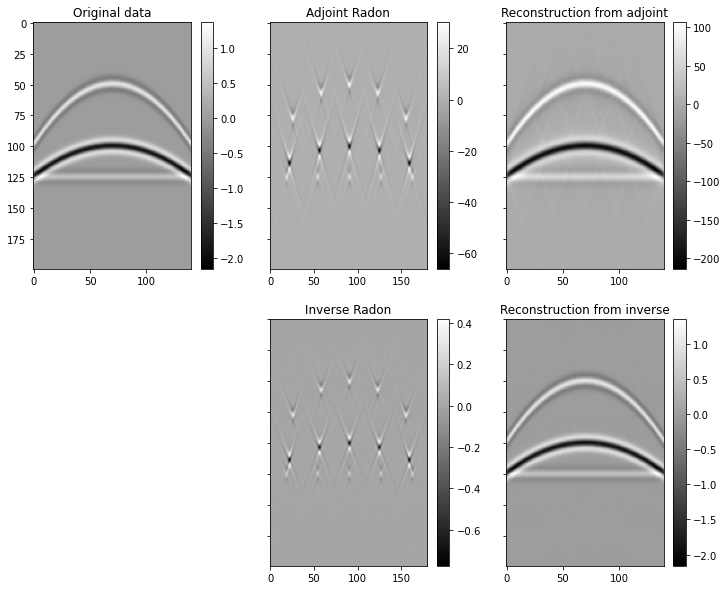

In [28]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
data = cp.array(parabolic2d(x, t, t0, px, pxx, amp, wav)[1])

nwins = 5
winsize = 36
overlap = 10
pxmax = 5e-3
dimsd = data.shape
dims = (nwins*winsize, par['nt'])

# Sliding window transform without taper
Op = ChirpRadon2D(t, cp.linspace(-par['dx']*winsize//2, par['dx']*winsize//2, winsize), pxmax*par['dx']/par['dt'])
Slid = Sliding2D(Op, dims, dimsd, winsize, overlap, tapertype=None)
dottest(Slid, Slid.shape[0], Slid.shape[1], verb=True, backend='cupy')

radon = Slid.H * data.ravel()
radon = radon.reshape(dims)

# Sliding window transform with taper
Slid = Sliding2D(Op, dims, dimsd, winsize, overlap, tapertype='hanning')

reconstructed_data = Slid * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dimsd)

# Inverse 
radoninv = LinearOperator(Slid, explicit=False).div(data.ravel(), niter=10)
reconstructed_datainv = Slid * radoninv.flatten()

radoninv = radoninv.reshape(dims)
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 10))
im = axs[0][0].imshow(cp.asnumpy(data.T), cmap='gray')
axs[0][0].set_title('Original data')
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis('tight')
im = axs[0][1].imshow(cp.asnumpy(radon.T), cmap='gray')
axs[0][1].set_title('Adjoint Radon')
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis('tight')
im = axs[0][2].imshow(cp.asnumpy(reconstructed_data.T), cmap='gray')
axs[0][2].set_title('Reconstruction from adjoint')
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis('tight')
axs[1][0].axis('off')
im = axs[1][1].imshow(cp.asnumpy(radoninv.T), cmap='gray')
axs[1][1].set_title('Inverse Radon')
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis('tight')
im = axs[1][2].imshow(cp.asnumpy(reconstructed_datainv.T), cmap='gray')
axs[1][2].set_title('Reconstruction from inverse')
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis('tight');

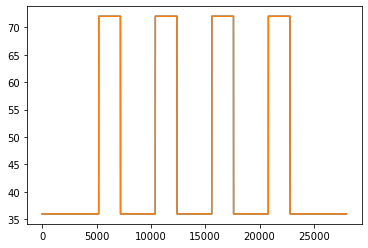

In [29]:
Op = ChirpRadon2D(t, np.linspace(-par['dx']*winsize//2, par['dx']*winsize//2, winsize), pxmax*par['dx']/par['dt'])
Slid = Sliding2D(Op, dims, dimsd, winsize, overlap, tapertype=None)

Op1 = ChirpRadon2D(t, cp.linspace(-par['dx']*winsize//2, par['dx']*winsize//2, winsize), pxmax*par['dx']/par['dt'])
Slid1 = Sliding2D(Op, dims, dimsd, winsize, overlap, tapertype=None)


y = Op * np.ones(Op.shape[1])
y1 = Op1 * cp.ones(Op.shape[1])

xadj = Op.H * y
xadj1 = Op1.H * y1

y = Slid * np.ones(Slid.shape[1])
y1 = Slid1 * cp.ones(Slid.shape[1])

xadj = Slid.H * y
xadj1 = Slid1.H * y1

y-cp.asnumpy(y1), xadj-cp.asnumpy(xadj1)

plt.plot(y)
plt.plot(cp.asnumpy(y1));

## Sliding3D

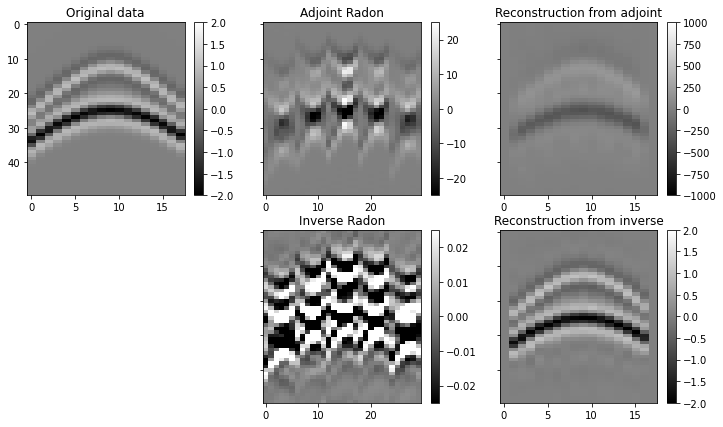

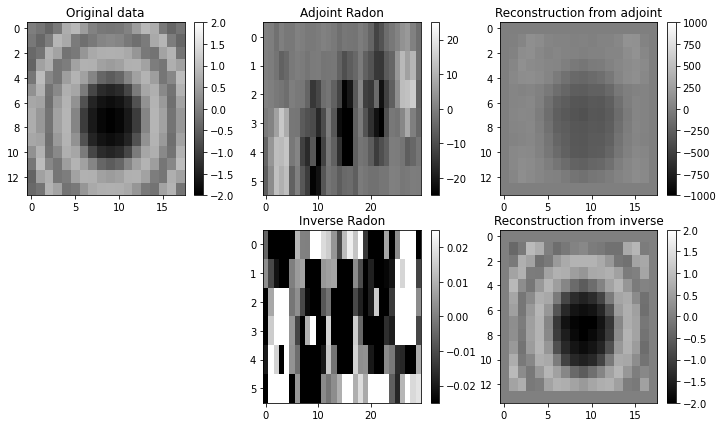

In [30]:
par = {'oy':-15, 'dy':2, 'ny':14,
       'ox':-18, 'dx':2, 'nx':18,
       'ot':0, 'dt':0.004, 'nt':50,
       'f0': 30}

vrms = [200, 200]
t0 = [0.05, 0.1]
amp = [1., -2]

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
data = hyperbolic3d(x, y, t, t0, vrms, vrms, amp, wav)[1]

# Sliding window plan
nwins = (3, 5)
winsize = (6, 6)
overlap = (2, 3)
npx = 6
pxmax = 5e-3

dimsd = data.shape
dims = (nwins[0]*npx, nwins[1]*npx, par['nt'])

# Sliding window transform without taper
Op = ChirpRadon3D(t, np.linspace(-par['dy']*winsize[0]//2, par['dy']*winsize[0]//2, winsize[0]),
                  np.linspace(-par['dx']*winsize[1]//2, par['dx']*winsize[1]//2, winsize[1]),
                  (pxmax*par['dx']/par['dt'], pxmax*par['dx']/par['dt']))
Slid = Sliding3D(Op, dims, dimsd, winsize, overlap, (npx, npx), tapertype=None)

radon = Slid.H * data.flatten()
radon = radon.reshape(nwins[0], nwins[1], npx, npx, par['nt'])

Slid = Sliding3D(Op, dims, dimsd, winsize, overlap, (npx, npx), tapertype='cosine')

reconstructed_data = Slid * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dimsd)

radoninv = LinearOperator(Slid, explicit=False).div(data.flatten(), niter=10)
reconstructed_datainv = Slid * radoninv.flatten()

radoninv = radoninv.reshape(nwins[0], nwins[1], npx, npx, par['nt'])
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 7))
im = axs[0][0].imshow(data[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0][0].set_title('Original data')
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis('tight')
im = axs[0][1].imshow(radon[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npx,
                                                               par['nt']).T,
                      cmap='gray', vmin=-25, vmax=25)
axs[0][1].set_title('Adjoint Radon')
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis('tight')
im = axs[0][2].imshow(reconstructed_data[par['ny']//2].T, cmap='gray',
                      vmin=-1000, vmax=1000)
axs[0][2].set_title('Reconstruction from adjoint')
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis('tight')
axs[1][0].axis('off')
im = axs[1][1].imshow(radoninv[nwins[0]//2, :, :, npx//2].reshape(nwins[1]*npx,
                                                                  par['nt']).T,
                      cmap='gray', vmin=-0.025, vmax=0.025)
axs[1][1].set_title('Inverse Radon')
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis('tight')
im = axs[1][2].imshow(reconstructed_datainv[par['ny']//2].T, cmap='gray',
                      vmin=-2, vmax=2)
axs[1][2].set_title('Reconstruction from inverse')
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis('tight')


fig, axs = plt.subplots(2, 3, figsize=(12, 7))
im = axs[0][0].imshow(data[:, :, 25], cmap='gray', vmin=-2, vmax=2)
axs[0][0].set_title('Original data')
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis('tight')
im = axs[0][1].imshow(radon[nwins[0]//2, :, :, :, 25].reshape(nwins[1]*npx,
                                                              npx).T,
                      cmap='gray', vmin=-25, vmax=25)
axs[0][1].set_title('Adjoint Radon')
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis('tight')
im = axs[0][2].imshow(reconstructed_data[:, :, 25], cmap='gray',
                      vmin=-1000, vmax=1000)
axs[0][2].set_title('Reconstruction from adjoint')
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis('tight')
axs[1][0].axis('off')
im = axs[1][1].imshow(radoninv[nwins[0]//2, :, :, :, 25].reshape(nwins[1]*npx,
                                                                 npx).T,
                      cmap='gray', vmin=-0.025, vmax=0.025)
axs[1][1].set_title('Inverse Radon')
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis('tight')
im = axs[1][2].imshow(reconstructed_datainv[:, :, 25],
                      cmap='gray', vmin=-2, vmax=2)
axs[1][2].set_title('Reconstruction from inverse')
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis('tight');

(18, 30, 50) (14, 18, 50)


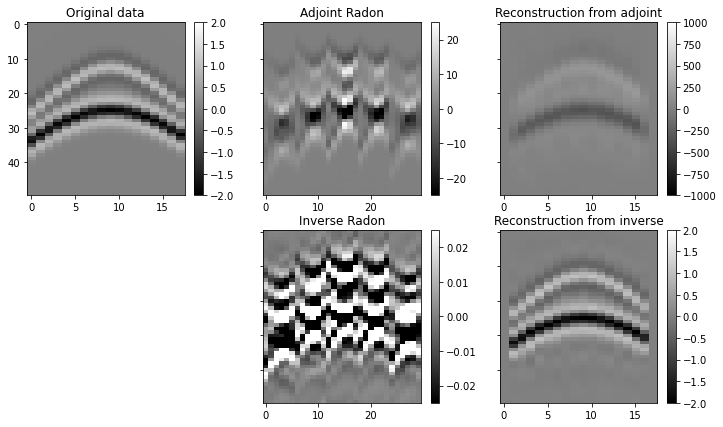

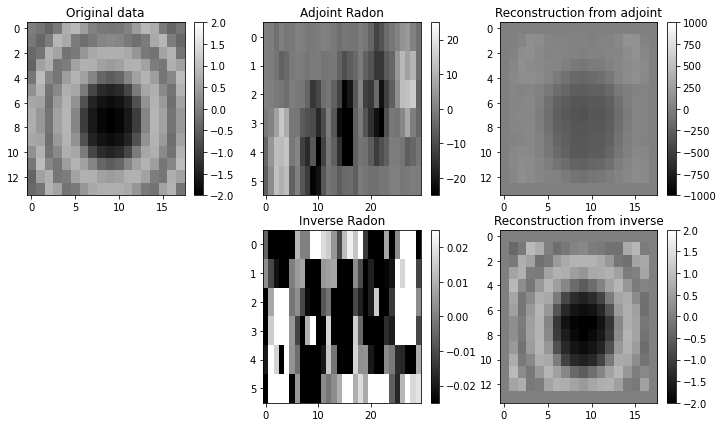

In [31]:
par = {'oy':-15, 'dy':2, 'ny':14,
       'ox':-18, 'dx':2, 'nx':18,
       'ot':0, 'dt':0.004, 'nt':50,
       'f0': 30}

vrms = [200, 200]
t0 = [0.05, 0.1]
amp = [1., -2]

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
data = hyperbolic3d(x, y, t, t0, vrms, vrms, amp, wav)[1]
data = cp.array(data)

# Sliding window plan
nwins = (3, 5)
winsize = (6, 6)
overlap = (2, 3)
npx = 6
pxmax = 5e-3

dimsd = data.shape
dims = (nwins[0]*npx, nwins[1]*npx, par['nt'])
print(dims, dimsd)
# Sliding window transform without taper
Op = ChirpRadon3D(t, cp.linspace(-par['dy']*winsize[0]//2, par['dy']*winsize[0]//2, winsize[0]),
                  cp.linspace(-par['dx']*winsize[1]//2, par['dx']*winsize[1]//2, winsize[1]),
                  (pxmax*par['dx']/par['dt'], pxmax*par['dx']/par['dt']))
Slid = Sliding3D(Op, dims, dimsd, winsize, overlap, (npx, npx), tapertype=None)

radon = Slid.H * data.flatten()
radon = radon.reshape(nwins[0], nwins[1], npx, npx, par['nt'])

Slid = Sliding3D(Op, dims, dimsd, winsize, overlap, (npx, npx), tapertype='cosine')

reconstructed_data = Slid * radon.flatten()
reconstructed_data = reconstructed_data.reshape(dimsd)

radoninv = LinearOperator(Slid, explicit=False).div(data.flatten(), niter=10)
reconstructed_datainv = Slid * radoninv.flatten()

radoninv = radoninv.reshape(nwins[0], nwins[1], npx, npx, par['nt'])
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 7))
im = axs[0][0].imshow(cp.asnumpy(data[par['ny']//2].T), cmap='gray', vmin=-2, vmax=2)
axs[0][0].set_title('Original data')
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis('tight')
im = axs[0][1].imshow(cp.asnumpy(radon[nwins[0]//2, :, :, npx//2]).reshape(nwins[1]*npx,
                                                               par['nt']).T,
                      cmap='gray', vmin=-25, vmax=25)
axs[0][1].set_title('Adjoint Radon')
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis('tight')
im = axs[0][2].imshow(cp.asnumpy(reconstructed_data[par['ny']//2].T), cmap='gray',
                      vmin=-1000, vmax=1000)
axs[0][2].set_title('Reconstruction from adjoint')
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis('tight')
axs[1][0].axis('off')
im = axs[1][1].imshow(cp.asnumpy(radoninv[nwins[0]//2, :, :, npx//2]).reshape(nwins[1]*npx,
                                                                  par['nt']).T,
                      cmap='gray', vmin=-0.025, vmax=0.025)
axs[1][1].set_title('Inverse Radon')
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis('tight')
im = axs[1][2].imshow(cp.asnumpy(reconstructed_datainv[par['ny']//2].T), cmap='gray',
                      vmin=-2, vmax=2)
axs[1][2].set_title('Reconstruction from inverse')
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis('tight')


fig, axs = plt.subplots(2, 3, figsize=(12, 7))
im = axs[0][0].imshow(cp.asnumpy(data[:, :, 25]), cmap='gray', vmin=-2, vmax=2)
axs[0][0].set_title('Original data')
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis('tight')
im = axs[0][1].imshow(cp.asnumpy(radon[nwins[0]//2, :, :, :, 25]).reshape(nwins[1]*npx,
                                                              npx).T,
                      cmap='gray', vmin=-25, vmax=25)
axs[0][1].set_title('Adjoint Radon')
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis('tight')
im = axs[0][2].imshow(cp.asnumpy(reconstructed_data[:, :, 25]), cmap='gray',
                      vmin=-1000, vmax=1000)
axs[0][2].set_title('Reconstruction from adjoint')
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis('tight')
axs[1][0].axis('off')
im = axs[1][1].imshow(cp.asnumpy(radoninv[nwins[0]//2, :, :, :, 25]).reshape(nwins[1]*npx,
                                                                 npx).T,
                      cmap='gray', vmin=-0.025, vmax=0.025)
axs[1][1].set_title('Inverse Radon')
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis('tight')
im = axs[1][2].imshow(cp.asnumpy(reconstructed_datainv[:, :, 25]),
                      cmap='gray', vmin=-2, vmax=2)
axs[1][2].set_title('Reconstruction from inverse')
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis('tight');